In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#load data
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
item_catigories = pd.read_csv('items.csv')
catigories = pd.read_csv('item_categories.csv')


In [3]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [4]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [5]:
test.columns

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [6]:
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,214200.0,107099.500000,61834.358168,0.0,53549.75,107099.5,160649.25,214199.0
shop_id,214200.0,31.642857,17.561933,2.0,16.00,34.5,47.00,59.0
item_id,214200.0,11019.398627,6252.644590,30.0,5381.50,11203.0,16071.50,22167.0


In [7]:
item_catigories.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [8]:
item_catigories.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


In [9]:
catigories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [10]:
catigories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


(array([2.935834e+06, 1.300000e+01, 1.000000e+00, 0.000000e+00,
        1.000000e+00]),
 array([ -22. ,  416.2,  854.4, 1292.6, 1730.8, 2169. ]),
 <a list of 5 Patch objects>)

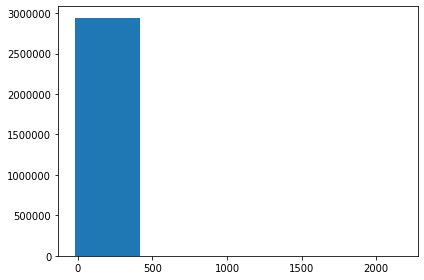

In [11]:
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)

axs.hist(train['item_cnt_day'], bins=5)


In [12]:
train = train.loc[(train.item_cnt_day < 669)]

# train.date = train.date.apply(lambda x:dt.datetime.strptime(x, '%d.%m.%Y'))
# train.date = train.date.apply(lambda x:dt.datetime.strftime(x,'%Y-%m'))

In [14]:
data = train.groupby(['date_block_num','item_id','shop_id']).sum().reset_index()
# print(data)
data = data[['date_block_num','item_id','shop_id','item_cnt_day','item_price']]
item_catigories = item_catigories[['item_id','item_category_id']]

# data.head(10)

table = pd.pivot_table(data, values='item_cnt_day', index=['item_id', 'shop_id'],
                        columns=['date_block_num'], aggfunc=np.sum).reset_index()

table = table.fillna(0)

data_form = table
# data_form = item_catigories.merge(table, on = ['item_id'], how = 'left')

data_form.head()


#get rid of those not in test data
# data_form = test.merge(table, on = ['item_id'], how = 'left')

# data_form = data_form.fillna(0)



date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
data.loc[(data['date_block_num'] > 1) & (data['shop_id'] == 2) & (data['item_id'] == 31)] 

,date_block_num,item_id,shop_id,item_cnt_day,item_price
123212,2,31,2,1.0,698.50
187177,3,31,2,1.0,699.00
882793,16,31,2,1.0,415.92
1577593,33,31,2,1.0,399.00


In [16]:
data_form.loc[(data_form['shop_id'] == 2) & (data_form['item_id'] == 31)] 

date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
154,31,2,0.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
data_form.columns

Index(['item_id', 'shop_id',         0,         1,         2,         3,
               4,         5,         6,         7,         8,         9,
              10,        11,        12,        13,        14,        15,
              16,        17,        18,        19,        20,        21,
              22,        23,        24,        25,        26,        27,
              28,        29,        30,        31,        32,        33],
      dtype='object', name='date_block_num')

In [18]:
# faad = data_from.loc[(data['date_block_num'] > 32) & (data['shop_id'] == 2)] 
# print(faad)

In [19]:
data_form.shape

(424124, 36)

In [58]:
guess_and_check = data_form
guess_and_check = guess_and_check.loc[guess_and_check['shop_id'] == 27]
guess_and_check = guess_and_check.loc[guess_and_check['item_id'] == 3423]
check_vals = guess_and_check.drop(columns=['shop_id','item_id']).T
print(check_vals.shape)
guess_and_check

(34, 1)


date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
53934,3423,27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,4.0,3.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0


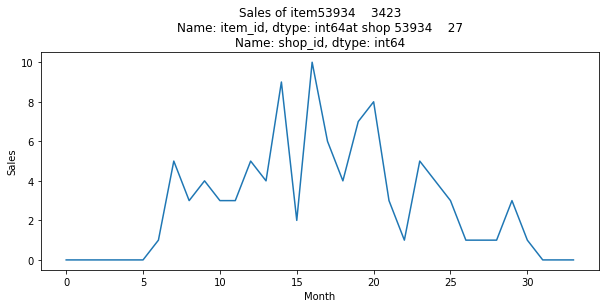

In [59]:
plt.figure(figsize =(10,4))
plt.title("Sales of item"+ str(guess_and_check['item_id']) + 'at shop '+ str(guess_and_check['shop_id']))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.plot(guess_and_check.columns[2:],check_vals)

In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(data_form.values.T)
dataset = dataset.T

In [21]:
print(dataset.shape)

(424124, 36)


In [25]:
X1, y1 = dataset[:,:35], dataset[:,35:36]
# X2, y2 = dataset[:,34:67], dataset[:,67:]

# X = np.concatenate(X1,X2)
# y = np.concatenate(y1,y2)
print(X1.shape)
print(y1.shape)


(424124, 35)
(424124, 1)


In [26]:
x_train, x_test, y_train, y_test = train_test_split(X1,y1,test_size=0.3,random_state=0)
#check shape of x_train and y_train
# reshape input to be [samples, time steps, features]
# print(y_train.shape)
# print(y_test.shape)

x_train= x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print(x_train.shape)
print(x_test.shape)

# x_train = x_train.reshape((297140, 36, 1))
# y_train = y_train.reshape((297140,1))
# x_test = x_test.reshape((127347, 36, 1))
# y_test = y_test.reshape((127347,1))
# x_train = x_train.reshape((593773, 33, 1))
# y_train = y_train.reshape((593773,1))
# x_test = x_test.reshape((254475, 33, 1))
# y_test = y_test.reshape((254475,1))

(296886, 1, 35)
(127238, 1, 35)


In [69]:
batch_size = 415#895#1660
def model_neural(): #change neurons
    model = Sequential()
    model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]),
                   stateful = False))
    model.add(Dense(1))
#     opt = optimizers.RMSprop()
    opt = optimizers.Adam()
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

    return model

model1 = model_neural()

#record training time
start=time.time()
training_model=model1.fit(x_train, y_train, validation_data = (x_test,y_test), batch_size = 895, epochs = 90, shuffle=False)
end=time.time()
print("--------------------------")
print("Total training time (seconds)", end-start)

# make predictions
trainPredict = model1.predict(x_train, batch_size = 895)
testPredict = model1.predict(x_test, batch_size = 895)

#test error
test_rmse = model1.evaluate(x_test, y_test,batch_size = 895)
print("--------------------------")
print('RMSE' , test_rmse[0])

Train on 296886 samples, validate on 127238 samples
Epoch 1/90
296886/296886 [==============================] - 5s 18us/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 7.5119e-06 - val_mean_squared_error: 7.5119e-06
Epoch 2/90
296886/296886 [==============================] - 4s 13us/step - loss: 7.8049e-06 - mean_squared_error: 7.8049e-06 - val_loss: 6.6869e-06 - val_mean_squared_error: 6.6869e-06
Epoch 3/90
296886/296886 [==============================] - 4s 14us/step - loss: 6.7766e-06 - mean_squared_error: 6.7766e-06 - val_loss: 5.7242e-06 - val_mean_squared_error: 5.7242e-06
Epoch 4/90
296886/296886 [==============================] - 4s 14us/step - loss: 5.6674e-06 - mean_squared_error: 5.6674e-06 - val_loss: 4.7671e-06 - val_mean_squared_error: 4.7671e-06
Epoch 5/90
296886/296886 [==============================] - 4s 14us/step - loss: 4.6121e-06 - mean_squared_error: 4.6121e-06 - val_loss: 3.9164e-06 - val_mean_squared_error: 3.9165e-06
Epoch 6/90
296886/296886 [=====

Epoch 45/90
296886/296886 [==============================] - 4s 15us/step - loss: 2.7457e-06 - mean_squared_error: 2.7457e-06 - val_loss: 1.8528e-06 - val_mean_squared_error: 1.8528e-06
Epoch 46/90
296886/296886 [==============================] - 4s 15us/step - loss: 2.7128e-06 - mean_squared_error: 2.7128e-06 - val_loss: 1.8635e-06 - val_mean_squared_error: 1.8635e-06
Epoch 47/90
296886/296886 [==============================] - 4s 15us/step - loss: 2.6805e-06 - mean_squared_error: 2.6805e-06 - val_loss: 1.8788e-06 - val_mean_squared_error: 1.8788e-06
Epoch 48/90
296886/296886 [==============================] - 4s 15us/step - loss: 2.6501e-06 - mean_squared_error: 2.6501e-06 - val_loss: 1.8970e-06 - val_mean_squared_error: 1.8970e-06
Epoch 49/90
296886/296886 [==============================] - 4s 15us/step - loss: 2.6210e-06 - mean_squared_error: 2.6210e-06 - val_loss: 1.9179e-06 - val_mean_squared_error: 1.9179e-06
Epoch 50/90
296886/296886 [==============================] - 4s 15us/s

296886/296886 [==============================] - 6s 20us/step - loss: 2.0139e-06 - mean_squared_error: 2.0139e-06 - val_loss: 1.8355e-06 - val_mean_squared_error: 1.8355e-06
Epoch 90/90
296886/296886 [==============================] - 6s 20us/step - loss: 2.0050e-06 - mean_squared_error: 2.0050e-06 - val_loss: 1.8331e-06 - val_mean_squared_error: 1.8331e-06
--------------------------
Total training time (seconds) 450.12702202796936
127238/127238 [==============================] - 1s 6us/step
--------------------------
RMSE 1.8330687021121358e-06


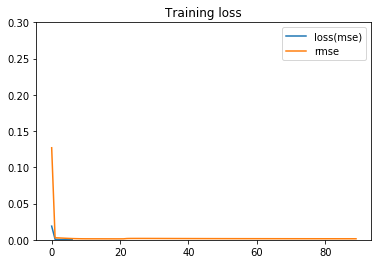

In [70]:
plt.plot(training1.history['loss'], label= 'loss(mse)')
plt.plot(np.sqrt(training_model.history['mean_squared_error']), label= 'rmse')
plt.title('Training loss')
plt.ylim(0,0.3)
plt.legend(loc=1)
plt.show()